In [40]:
import os
import torch
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from torch import nn
from tqdm import tqdm

import sys
sys.path.append('../src/data')
sys.path.append('../src/')
sys.path.append('../src/utils')

from datasets import CelebaDataset, WFLWDataset
import landmark_transforms
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from trainer import Trainer

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

In [41]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")
def generate_predictions(model,
                         dataloader,
                         forward_args = {},
                         numclasses = 5*2,
                         device = torch.device('cuda')):
    y_pred = np.zeros((0,int(numclasses/2), 2))
    y = np.zeros((0,int(numclasses/2), 2))
    
    model.eval()
    with torch.no_grad():
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            inputs = batch['image'].to(device=device)
            labels = batch['landmarks'].numpy()

            outputs = model(inputs, **forward_args).cpu().view(-1, int(numclasses/2), 2).numpy()  # (batch_size, length, num_classes)
            
            y_pred = np.concatenate((y_pred, outputs), axis=0)
            y = np.concatenate((y, labels), axis=0)
                
    return y_pred, y

Running on device: cuda


In [42]:
wflw_data_loc = '/home/data/wflw/'

train_dataset = WFLWDataset(wflw_data_loc + 'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt', wflw_data_loc + 'WFLW_images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)
val_dataset = WFLWDataset(wflw_data_loc + 'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt', wflw_data_loc + 'WFLW_images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)
test_dataset = WFLWDataset(wflw_data_loc + 'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt', wflw_data_loc + 'WFLW_images',
                        transform=transforms.Compose([
                            transforms.ToTensor(), 
                            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                        ]), 
                        landmark_transform=transforms.Compose([
                            landmark_transforms.Rescale(224),
                            landmark_transforms.NormalizeLandmarks()
                        ]), crop=True)

trainloader_params = {
    'dataset': train_dataset,
    'batch_size': 8,
    'shuffle': False
}
train_dataloader = DataLoader(**trainloader_params)

valloader_params = {
    'dataset': val_dataset,
    'batch_size': 4,
    'shuffle': False
}
val_dataloader = DataLoader(**valloader_params)

testloader_params = {
    'dataset': test_dataset,
    'batch_size': 4,
    'shuffle': False
}
test_dataloader = DataLoader(**testloader_params)

In [43]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

animal_baseline_resnet_nopretrain_transforms_1/
animal_baseline_resnet_wingloss_1/
celeba_baseline_resnet_wingloss_1/
wflw_baseline_resnet_wingloss_1/
wflw_baseline_resnet_wingloss__notransform_1/


In [44]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_baseline_resnet_wingloss_1/"

checkpoint_0/   checkpoint_15/  checkpoint_21/  checkpoint_6/
checkpoint_1/   checkpoint_16/  checkpoint_22/  checkpoint_7/
checkpoint_10/  checkpoint_17/  checkpoint_23/  checkpoint_8/
checkpoint_11/  checkpoint_18/  checkpoint_24/  checkpoint_9/
checkpoint_12/  checkpoint_19/  checkpoint_3/   checkpoint_batch_0/
checkpoint_13/  checkpoint_2/   checkpoint_4/
checkpoint_14/  checkpoint_20/  checkpoint_5/


In [45]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_baseline_resnet_wingloss_1/checkpoint_24/results.csv"
model_results = pd.read_csv(model_path)

In [46]:
num_landmarks = 98
y = model_results['y'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
y_pred = model_results['y_pred'].to_numpy().reshape(-1, 2).reshape(-1, num_landmarks, 2)
print(y.shape, y_pred.shape)

# To convert into (NxD) just change view

(2500, 98, 2) (2500, 98, 2)


In [47]:
def show_landmarks(image, landmarks, norm=True):
    """Show image with landmarks"""
    if norm:
        inv_normalize = transforms.Normalize(
           mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
           std=[1/0.229, 1/0.224, 1/0.225]
        )
        image = inv_normalize(image)
        
    
    plt.imshow(transforms.ToPILImage()(image))
    plt.scatter(landmarks[:, 0] * image.shape[-1], landmarks[:, 1] * image.shape[-2], s=10, marker='.', c='b')
    plt.pause(0.001)  # pause a bit so that plots are updated

Pred


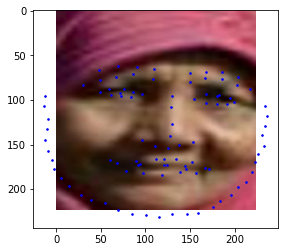

Truth


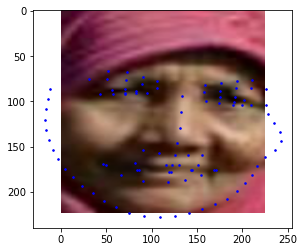

tensor([[0, 0, 0, 0, 0, 0]], dtype=torch.int32)


In [81]:
img_num = 2499

plt.figure()
sample = test_dataset[img_num]
print('Pred')
show_landmarks(sample['image'], y_pred[img_num])
print('Truth')
show_landmarks(sample['image'], y[img_num])
plt.show()
print(sample['attributes'])

# Only run once to generate predictions

In [ ]:
# Outputs model checkpoints
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints"

In [ ]:
# View model to evaluate
%ls "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_baseline_resnet_nopretrain_1/"

In [ ]:
model_path = "/home/erikrozi/facial_landmark_debiasing/src/experiments/checkpoints/wflw_baseline_resnet_wingloss_1/checkpoint_24/model.pt"
model = torch.load(model_path).to(device)

In [ ]:
y_pred, y = generate_predictions(model, test_dataloader, numclasses=98*2, device=device)

In [ ]:
data_dict = {
    'y': y.flatten(),
    'y_pred': y_pred.flatten()
}

pred_df = pd.DataFrame(data_dict)
results_csv_path = model_path.replace('model.pt', f'results.csv')
pred_df.to_csv(results_csv_path, index=False)

# Evaluation

In [162]:
# load data and predictions
x = pd.read_csv(wflw_data_loc+'WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt').values
y_hat = y_pred[:-1, :, :]
y_new = y[:-1, :, :]

num_samples = len(x)
total_size = len(x[0][0].split()[:-1])

x = [x[i][0].split()[:-1] for i in range(num_samples)]
x = np.asarray(x, dtype=np.float).reshape(num_samples, total_size)[:, -6:]

num_samples, num_features = x.shape

assert(y_hat.shape == y_new.shape)
print('Num_samples:', num_samples) 
print('Num_features:', num_features) 

Num_samples: 2499
Num_features: 6


In [163]:
# define d to be either interocular distance or bounding box diagonal length
d = np.array([1*2**0.5]*num_samples)

In [164]:
"""
Z = list of lists, where each entry is [sensitive attribute column number, majority condition]
alpha = failure rate threshold   
calculate_landmark: if True, calculates certain bias metrics overall and per landmark. if false, only overall
"""
counts = np.sum(x, axis=0)
maj = np.where(counts > num_samples/2, 1, 0)
Z = [[i,maj[i]] for i in range(num_features)]

alpha = 0.001
beta = 1
# calculate_landmark = True

In [171]:
""" Accuracy Metrics: Normalized Mean Error (NME) and CED/AUC/FR
y, y_hat have dimensions of n x m
d is the interocular distance
"""

def calc_nme_images(y_hat, y, m, d):
    # Output: NME of each image over all landmarks (size n)
    #nme = np.square(np.linalg.norm((y_hat-y)/np.expand_dims(d, (1,2)), axis=(1,2)))
    return np.square(np.linalg.norm(y_hat-y, axis=(1,2))) / d

def calc_nme_landmark(y_hat, y, m, d):
    # Output: NME of each image for each facial landmark (size n x m/2)
    nme = np.square(y_hat-y)  
    return np.sqrt(np.mean(nme, axis=2)) / d[:, np.newaxis]

def calc_total_nme(nme):
    # Output: average NME across all images
    return np.mean(nme, axis=0)

def create_ced(nme):
    # Output: plot of the CED
    x = np.sort(nme)
    y = np.arange(nme.shape[0]) / float(nme.shape[0])
    plt.xlabel('Normalized Mean Error (NME)')
    plt.ylabel('Percent of Samples')
  
    plt.title('Plot of Cumulative Error Distribution (CED) Curve')
    plt.plot(x, y, marker='o')
    plt.show

def calc_auc(nme, alpha):
    # Output: percentage of samples with nme=0 to alpha
    num_under_alpha = np.where(nme < alpha, 1, 0)
    return np.sum(num_under_alpha) / nme.shape[0]

def calc_fr(nme, alpha):
    # Output: failure rate, where failure is defined w.r.t a threshold, alpha (percent of samples with nme>alpha)
    return 1-calc_auc(nme, alpha)

In [172]:
nme_images = calc_nme_images(y_hat, y_new, num_landmarks, d)
nme_landmark = calc_nme_landmark(y_hat, y_new, num_landmarks, d)
total_nme = calc_total_nme(nme_images)
total_nme_landmark = calc_total_nme(nme_landmark)
fr = calc_fr(nme_images, alpha)

print(np.mean(total_nme_landmark))
print('Average Normalized Mean Error:', total_nme, '\n')
print('Average Normalized Mean Error Per Landmark')
for i in range(num_landmarks):
    print(f'Landmark {i}: {total_nme_landmark[i]}')
print('\n')
print(f'Failure Rate Threshold at {alpha}: {fr}')

0.018643748155341987
Average Normalized Mean Error: 0.18088522000991014 

Average Normalized Mean Error Per Landmark
Landmark 0: 0.029451828631898345
Landmark 1: 0.027743906042559656
Landmark 2: 0.02685273341045492
Landmark 3: 0.025955907774637764
Landmark 4: 0.02528987140159091
Landmark 5: 0.02465905692959016
Landmark 6: 0.023811734227907683
Landmark 7: 0.023502948254674395
Landmark 8: 0.0231186773511763
Landmark 9: 0.0227212209679428
Landmark 10: 0.022241528156079392
Landmark 11: 0.021978671819734397
Landmark 12: 0.02214975094898611
Landmark 13: 0.021574172714671627
Landmark 14: 0.02181323455589126
Landmark 15: 0.022939993477683832
Landmark 16: 0.02275770069453328
Landmark 17: 0.022728862031771317
Landmark 18: 0.021365428939514826
Landmark 19: 0.021073444550767834
Landmark 20: 0.02187807891518103
Landmark 21: 0.021784974242977886
Landmark 22: 0.022310167123966818
Landmark 23: 0.02251217200287889
Landmark 24: 0.022750196614582757
Landmark 25: 0.02307463656518563
Landmark 26: 0.0233349

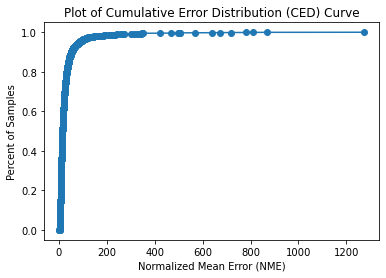

In [144]:
ced = create_ced(nme_images)

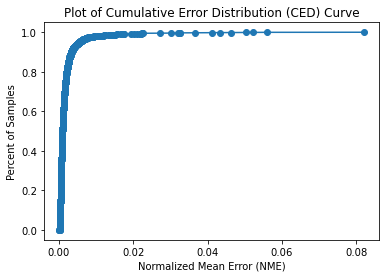

In [31]:
no_outliers = nme_images[np.where(nme_images<beta)]
ced = create_ced(no_outliers)

In [32]:
"""Bias Metrics: Majority/Minority Difference in Error/Failure (MMD)"""
def calc_mmd_err(majority, minority):
    difference = np.mean(majority, axis=0) - np.mean(minority, axis=0)
    return difference

def calc_mmd_fr(majority, minority, alpha):
    difference = calc_fr(majority, alpha) - calc_fr(minority, alpha)
    return difference

In [33]:
""" Within each loop:
z = sensitive attribute group (as column number)
maj = value of majority group
nme = num_samples dimension tensor
"""

mmd_err = {}
mmd_fr = {}


# if calculate_landmark:
#     mmd_error_landmarks = {}

# calculates MMD Error and MMD Failure averaged across all landmarks
for z, maj in Z:
    majority = nme_images[np.where(x[:, z] == maj)] # size # images in majority
    minority = nme_images[np.where(x[:, z] != maj)] # size # images in minority

    mmd_err[z] = calc_mmd_err(majority, minority)
    mmd_fr[z] = calc_mmd_fr(majority, minority, alpha)

# calculates MMD Error for each landmark    
# if calculate_landmark:
#     for z, maj in Z:
#         majority = nme_landmark[np.where(x[:, z] == maj)] # size # images in majority x m/2
#         minority = nme_landmark[np.where(x[:, z] != maj)] # size # images in minority x m/2
#         mmd_error_landmarks[z] = calc_mmd_err(majority, minority)

In [34]:
print('MMD in Error per Attribute')
for z, error in mmd_err.items():
    print(f'Attribute {z}: {error}')

MMD in Error per Attribute
Attribute 0: -0.001488031694748356
Attribute 1: -6.772185103311981e-05
Attribute 2: 0.0002737539568825975
Attribute 3: 0.00014346589720697664
Attribute 4: -0.0006975224066005201
Attribute 5: -0.00032183645416784226


In [35]:
print('MMD in Failure Rate')
for z, error in mmd_fr.items():
    print(f'Attribute {z}: {error}')

MMD in Failure Rate
Attribute 0: 0.0
Attribute 1: 0.0
Attribute 2: 0.0
Attribute 3: 0.0
Attribute 4: 0.0
Attribute 5: 0.0
